# A/B test results by Anthony Rogers

In this notebook I'll go over the process of analysing an A/B test, from formulating a hypothesis, testing it, and finally interpreting results. I'll be using a [dataset from Kaggle](https://www.kaggle.com/faviovaz/marketing-ab-testing) which contains the results of an A/B test on 2 different marketing strategies (PSA vs. Ad). Here's the process:

1. [Designing the experiment](#Designing-the-experiment)
2. [Data Exploration and preparation](#Data-Exploration-and-preparation)
3. [Visualising the results](#Visualising-the-results)
4. [Hypothesis testing](#Hypothesis-testing)
5. [Drawing conclusions](#Drawing-conclusions)

Lets create a Real world senario:
> Lets assume you are a data analyst on the marketing team. The marketing manager wants to know if the Ads will have a higher conversion rate than the public service anouncements (PSA). According the the marketing manager, the **current conversion rate is about 19%** on average throughout the year, and that the team would be happy with an increase of **5%**, meaning that the new design will be considered a success if it raises the conversion rate to 24%.

Before making a deciscion, the team would be more comfortable testing it on a smaller number of users to see how it performs, so you suggest running an A/B test on a subset of your userbase.


#  1. Designing the experiment 

## Formulating a hypothesis
First things first, we want to make sure we formulate a hypothesis at the start of our project. This will make sure our interpretation of the results is correct as well as rigorous.

Given we don't know if the new design will perform better or worse (or the same?) as our current design, we'll choose a **two-tailed test**:

where  and  stand for the conversion rate of the new and old design, respectively. We'll also set a confidence level of 95%:

The value is a threshold we set, by which we say "if the probability of observing a result as extreme or more (-value) is lower than , then we reject the null hypothesis". Since our  (indicating 5% probability), our confidence (1 - ) is 95%.

Choosing the variables
For our test we'll need two groups:

A control group - They'll be shown the PSA

A treatment (experimental) group - They'll be shown the Ad

This will be the Independent Variable. The reason we have two groups even though we know the baseline conversion rate is that we want to control for other variables that could have an effect on our results, such as the number of ads seen: by having a control group we can directly compare their results to the treatment group, because the only systematic difference between the groups is the type of marketing presentation, so we can therefore attribute any differences in results to them.

For our Dependent Variable (i.e. what we are trying to measure), we are interested in capturing the conversion rate. A way we can code this is by each user session with a binary variable:

0 - The user did not buy the product during this user session

1 - The user bought the product during this user session

With this in mind, you can easily calculate the mean for each group to get the conversion rate of each design.

### Choosing a sample size
It is important to note that since we won't test the whole user base (our population), the conversion rates that we'll get will inevitably be only estimates of the true rates.

The number of people (or user sessions) we decide to capture in each group will have an effect on the precision of our estimated conversion rates: the larger the sample size, the more precise our estimates (i.e. the smaller our confidence intervals), the higher the chance to detect a difference in the two groups, if present.

On the other hand, the larger our sample gets, the more expensive (and impractical) our study becomes.

So how many people should we have in each group?

The sample size can be estimated through something called [*Power analysis*](https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/), and it depends on a few factors:

- Power of the test () : This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 as a convention.
- Alpha value () : The critical value we set earlier to 0.05
- Effect size : How big of a difference we expect there to be between the conversion rates
Since our team would be happy with a difference of 5%, we can use 19% and 24% to calculate the effect size we expect.

In [1]:
import pandas as pd
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [5]:
effect_size = sms.proportion_effectsize(0.19, 0.24)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

1057


I need 1057 observations for both the control and treatment group.

## Data Exploration and preparation

In [3]:
df = pd.read_csv("marketing_ab.csv", index_col=[0])
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [8]:

df.rename(columns={'user id': 'user_id', 
                   "test group": "test_group", 
                   "total ads":"total_ads", 
                   "most ads day":"most_ads_day", 
                   "most ads hour":"most_ads_hour"}, inplace=True)
df.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [31]:
df.shape

(588101, 6)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 43.6+ MB


In [12]:
#Check for unique user ID
df['user_id'].nunique()

588101

In [13]:
# Another way to check duplicate user ID
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 0 users that appear multiple times in the dataset


In [10]:
# check for missing values
df.isnull().sum()

user_id          0
test_group       0
converted        0
total_ads        0
most_ads_day     0
most_ads_hour    0
dtype: int64

In [16]:
# Many people converted?
df['converted'].value_counts()

False    573258
True      14843
Name: converted, dtype: int64

In [40]:
# The proportion of users converted.
df.converted.mean() 

0.02523886203220195

 What's the probability that an individual in the control group converted?

In [44]:
#Using Bayes' Theorem
control_ver =float(df.query("test_group=='psa' and converted==True")['user_id'].nunique() ) 
control = float(df.query("test_group=='psa'")['user_id'].nunique())
round(control_ver / control,4)

0.0179

What's the probability that an individual in the treatment group converted?

In [45]:
#Using Bayes' Theorem
treat_ver =float(df.query("test_group=='ad' and converted==True")['user_id'].nunique() ) 
treat = float(df.query("test_group=='ad'")['user_id'].nunique())
round(treat_ver / treat,4)

0.0255

# Sampling the data

In [9]:
control_sample = df[df['test_group'] == 'psa'].sample(n=required_n, random_state=22)
treatment_sample = df[df['test_group'] == 'ad'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [10]:
ab_test

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,916702,psa,False,7,Monday,17
1,911687,psa,False,2,Saturday,23
2,911494,psa,False,6,Friday,21
3,922101,psa,False,15,Friday,10
4,904432,psa,False,23,Sunday,10
...,...,...,...,...,...,...
2109,1328434,ad,False,7,Tuesday,21
2110,1001610,ad,False,21,Tuesday,10
2111,1420233,ad,False,7,Friday,14
2112,1373793,ad,False,1,Wednesday,17


In [36]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2114 entries, 0 to 2113
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        2114 non-null   int64 
 1   test_group     2114 non-null   object
 2   converted      2114 non-null   bool  
 3   total_ads      2114 non-null   int64 
 4   most_ads_day   2114 non-null   object
 5   most_ads_hour  2114 non-null   int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 84.8+ KB


In [37]:
ab_test['test_group'].value_counts()

psa    1057
ad     1057
Name: test_group, dtype: int64

## Visualising the results

In [41]:
conversion_rates = ab_test.groupby('test_group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
test_group,,,
ad,0.027,0.163,0.005
psa,0.025,0.155,0.005


The conversion rates for both groups are very close, but the treatment group hs a higher conversion of 2.7% vs the 2.5% of the control group

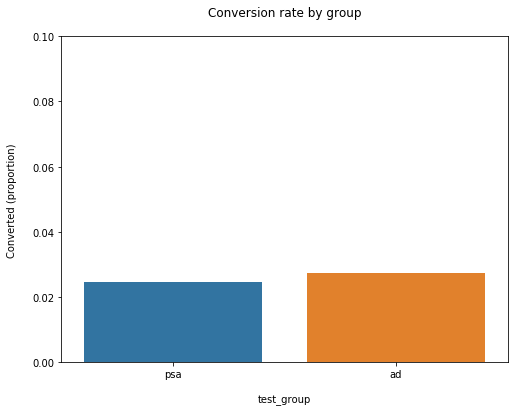

In [48]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['test_group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.10)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('test_group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

# Hypothesis testing

The final step is to test our hypothesis. We can use normal approximation to calculate our p-value.

In [13]:
control_results = ab_test[ab_test['test_group'] == 'psa']['converted']
treatment_results = ab_test[ab_test['test_group'] == 'ad']['converted']

In [14]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.41
p-value: 0.682
ci 95% for control group: [0.015, 0.034]
ci 95% for treatment group: [0.018, 0.037]


 # Drawing conclusions
 
 Since our p-value= 0.682 is above our =0.05, we cannot reject the null hypothesis , which means the ad did not perform significantly different than the psa.

Additionally, if we look at the confidence interval for the treatment group ([0.018, 0.037], i.e. 1.8 - 3.7%) we notice that:

- It does not include our baseline value of 19% conversion rate
- It also does not include our target value of 24% (the 5% uplift we were aiming for)

This means that the correction conversion rate is far from the baseline of 19% and our target of 24%. This also means that there isnt much of a diffence between the Ads and Psa, so we need to rework our marketing plan.